# Imports

In [1]:
import os
import re

#from nltk.tokenize import word_tokenize

#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.fixes import signature
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

import operator
import matplotlib.pyplot as plt

import numpy as np
from numpy import array

In [2]:
np.random.seed(7)

# Using all 10 data folders for training and validation, splitting them later at random

## You can use 10-fold cross validation experiments for HYPER PARAMETER TUNING

In [3]:
#directory_path = r"C:\Users\Κωστας\Desktop\SpamHam_NLP\lingspam_public\lemm"

In [4]:
directory_path = "/media/spiros/Data/lingspam_public/bare/"

# Load txt files and create a mail list (inputs) and a spam/ham list (outputs)

In [5]:
#spam_ham_tuple_list = list()
mails = list()
spams = list()
for folder in os.listdir(directory_path):
    for file in os.listdir(os.path.join(directory_path, folder)):
        if file.endswith(".txt"):
            with open(os.path.join(directory_path, folder, file), encoding='utf8') as f:
                mail = f.read().strip()
                # Clean each mail
                # Remove all the special characters
                #mail = re.sub(r'\W', ' ', mail)

                # Remove all single characters
                #mail = re.sub(r'\s+[a-zA-Z]\s+', ' ', mail)

                # Substituting multiple spaces with single space
                mail = re.sub(r'\s+', ' ', mail, flags=re.I)

                # Convert to Lowercase
                mail = mail.lower()
                
                mails.append(mail)
                
                if file.startswith("spm"):
                    #spam_ham_tuple_list.append((mail,1))
                    spams.append(1)
                else:
                    #spam_ham_tuple_list.append((mail,0))
                    spams.append(0)

In [6]:
# mail_word_sequences = list()
# for mail, spam in spam_ham_tuple_list:
#     mail_word_sequences.append((word_tokenize(mail), spam))

In [7]:
# mails = list()
# spams = list()
# for mail, spam in spam_ham_tuple_list:
#     mails.append(mail)
#     spams.append(spam)

## Much more ham than spam mails, however if the recall turns out to be high, I suggest not adding more copies of spam mails in order to achieve a 50-50 distribution

In [8]:
unique, counts = np.unique(spams, return_counts=True)
print("Ham mails count: "+str(counts[0]))
print("Spam mails count: "+str(counts[1]))

Ham mails count: 2412
Spam mails count: 481


In [9]:
y = array(spams)
#dictionary = dict(zip(X, y))
#dictionary=DictVectorizer()
#dictionary.get_feature_names()


# Train Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(mails, y, test_size=0.2, shuffle=True)

# TF-IDF

### From https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html:

### max_df : float in range [0.0, 1.0] or int (default=1.0) When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts.

### min_df : float in range [0.0, 1.0] or int (default=1) When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts.

### max_features : int or None (default=None) If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

### ngram_range : tuple (min_n, max_n) (default=(1, 1)) The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such that min_n <= n <= max_n will be used.

In [11]:
tfidfconverter = TfidfVectorizer(min_df=10, max_df=0.8, stop_words='english', ngram_range=(1,3)
                                 , max_features=1000
                                )  
X_train = tfidfconverter.fit_transform(X_train).toarray()

X_test = tfidfconverter.transform(X_test).toarray()

In [12]:
X_train[1]

array([0.11149372, 0.        , 0.20247394, 0.02532132, 0.02810661,
       0.        , 0.24632245, 0.027282  , 0.14473536, 0.10207826,
       0.02781915, 0.        , 0.        , 0.12384493, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01357244, 0.        , 0.        ,
       0.06247045, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.15545923, 0.        , 0.        , 0.        ,
       0.        , 0.02495981, 0.18576739, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.25947038, 0.        ,
       0.        , 0.        , 0.15182552, 0.        , 0.        ,
       0.10153488, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0360558 , 0.04074827, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

## Input and output feature vectors dimensions

In [13]:
X_train.shape

(2314, 1000)

In [14]:
X_test.shape

(579, 1000)

In [15]:
y_train.shape

(2314,)

In [16]:
y_test.shape

(579,)

# Information gain / Mutual Information feature selection

In [16]:
def mutual_info_classif_custom(X, y):
    return mutual_info_classif(X, y, discrete_features=True)

In [17]:
# X_train = SelectKBest(mutual_info_classif_custom, k=1000).fit_transform(X_train, y_train)
# X_test = SelectKBest(mutual_info_classif_custom, k=1000).fit_transform(X_test, y_test)

In [19]:
# a=0.88
# #takes an argument "a" and cuts the a% percentage of the features with the lower Information Gain
# def InformationGain(a,X,y):
#     inf_gain = mutual_info_classif(X, y, discrete_features=True)
#     print(len(inf_gain))
#     #inf_gain.shape
#     res = dict(zip(tfidfconverter.get_feature_names(),inf_gain))
#     res_sort = sorted(res.items(), key=operator.itemgetter(1), reverse=True)
#     y=len(res)
#     if a>=0 and a<=1:
#         while (1-a)*y<=len(res_sort):
#             res_sort.pop()
#     else :
#         print("Not acceptable argument for variable 'a'")
        
#     #print(res_sort)
#     return res_sort

In [1]:
#X_train.shape

NameError: name 'X_train' is not defined

# PCA Dimensonality reduction (Does nothing for now)

Text(0, 0.5, 'Cumulative explained variance')

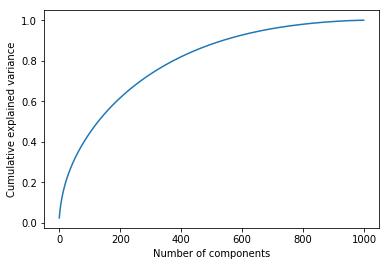

In [20]:
pca = PCA()
pca.fit(X_train)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

### Seems to have much lower recall with PCA

In [21]:
#pca = PCA(n_components=2000)
#pca.fit(X_train)
#X_train = pca.transform(X_train)

#X_test = pca.transform(X_test)

# Truncated SVD Dimensonality reduction (Does nothing for now)

Text(0, 0.5, 'Cumulative explained variance')

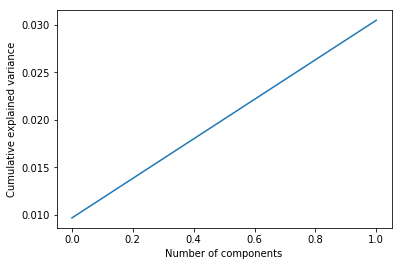

In [22]:
svd = TruncatedSVD()
svd.fit(X_train)


plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

# svd = TruncatedSVD(n_components=500)
# svd.fit(X_train)
# X_train = svd.transform(X_train)
# X_test = svd.transform(X_test)

In [17]:
# Define learning curves plot function
def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10), scoring='f1_macro'):

    plt.figure()
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring= scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

# Train model function

In [18]:
def train(model, X_train, y_train):
    model.fit(X_train, y_train) 
    
    # Random permutation cross-validator
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    plot_learning_curve(model, X_train, y_train, (0.1, 1.01), cv=cv, n_jobs=2)

    plt.show()
    

# Evaluate model function

In [19]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))  
    print("Accuracy: "+str(accuracy_score(y_test, y_pred))) 
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall_curve, precision_curve, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall_curve, precision_curve, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')

# GridSearchCV function for hyperparameter tuning

In [50]:
def hyper_parameter_tuning(param_grid, model, cv):
    #Set-up Grid Search and start fit
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=1, n_jobs=10)
    grid.fit(X_train, y_train)

    #Print best option
    print("Best options")
    print("=======================================")
    for param_name in sorted(param_grid.keys()):
         print("%s: %r" % (param_name, grid.best_params_[param_name]))
            
    return grid.best_params_

# Dummy classifier

## Training

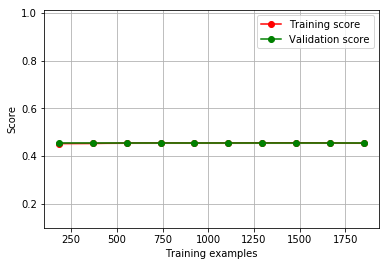

In [26]:
dummy = DummyClassifier(strategy='most_frequent')  
train(dummy, X_train, y_train)

## Evaluation

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       484
           1       0.00      0.00      0.00        95

   micro avg       0.84      0.84      0.84       579
   macro avg       0.42      0.50      0.46       579
weighted avg       0.70      0.84      0.76       579

Accuracy: 0.8359240069084629


/home/spiros/env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


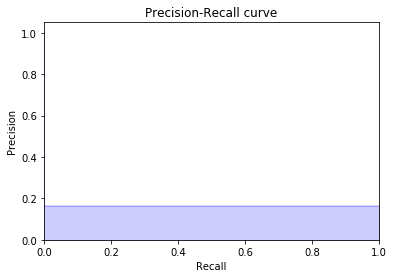

In [27]:
evaluate(dummy, X_test, y_test)

# Random Forest

## Hyperparameter tuning with GridsearchCV

In [73]:
param_grid=param_grid = { 
    'n_estimators': [200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None, 4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
best_parameters = hyper_parameter_tuning(param_grid , RandomForestClassifier(random_state=0), 3)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   30.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 324 out of 324 | elapsed:  2.9min finished


Best options
criterion: 'entropy'
max_depth: None
max_features: 'auto'
n_estimators: 500


## Training with best parameters

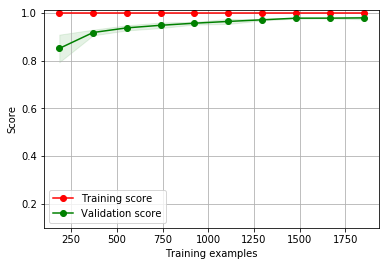

In [74]:
random_forest = RandomForestClassifier(random_state=0, **best_parameters) 
train(random_forest, X_train, y_train)

## Evaluation

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       484
           1       1.00      0.94      0.97        95

   micro avg       0.99      0.99      0.99       579
   macro avg       0.99      0.97      0.98       579
weighted avg       0.99      0.99      0.99       579

Accuracy: 0.9896373056994818


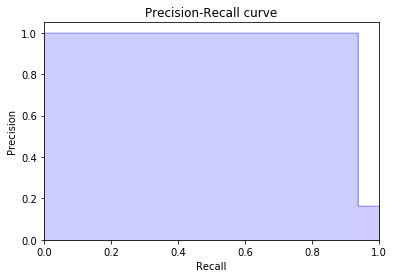

In [75]:
evaluate(random_forest, X_test, y_test)

# Logistic Regression

## Hyperparameter tuning with GridsearchCV

In [51]:
param_grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "solver":["liblinear"]} # l1 lasso l2 ridge
best_parameters = hyper_parameter_tuning(param_grid , LogisticRegression(random_state=0), 3)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Best options
C: 100.0
penalty: 'l2'
solver: 'liblinear'


[Parallel(n_jobs=10)]: Done  42 out of  42 | elapsed:    2.3s finished


## Training with best parameters

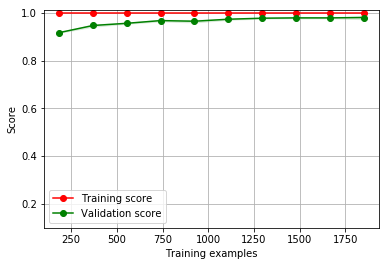

In [52]:
logistic = LogisticRegression(random_state=0, **best_parameters) 
train(logistic, X_train, y_train)

## Evaluation

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       484
           1       1.00      0.95      0.97        95

   micro avg       0.99      0.99      0.99       579
   macro avg       0.99      0.97      0.98       579
weighted avg       0.99      0.99      0.99       579

Accuracy: 0.9913644214162349


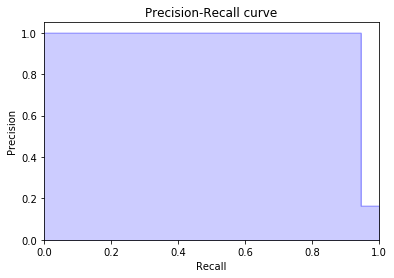

In [53]:
evaluate(logistic, X_test, y_test)

# Naive Bayes

## No hyperparameters to tune

## Training

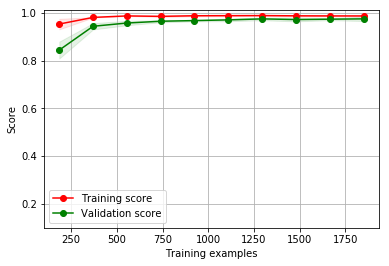

In [56]:
naive_bayes = MultinomialNB()  
train(naive_bayes, X_train, y_train)

## Evaluation

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       484
           1       0.99      0.97      0.98        95

   micro avg       0.99      0.99      0.99       579
   macro avg       0.99      0.98      0.99       579
weighted avg       0.99      0.99      0.99       579

Accuracy: 0.9930915371329879


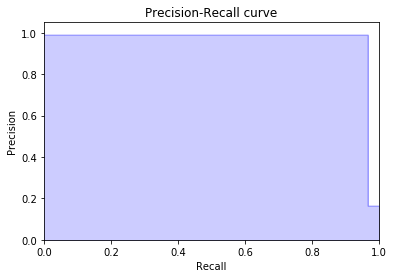

In [57]:
evaluate(naive_bayes, X_test, y_test)

# k-NN

## Hyperparameter tuning with GridsearchCV

In [59]:
param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
                                            14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
best_parameters = hyper_parameter_tuning(param_grid , KNeighborsClassifier(), 3)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   57.7s


Best options
n_neighbors: 25
weights: 'distance'


[Parallel(n_jobs=10)]: Done 180 out of 180 | elapsed:  5.4min finished


## Training with best parameters

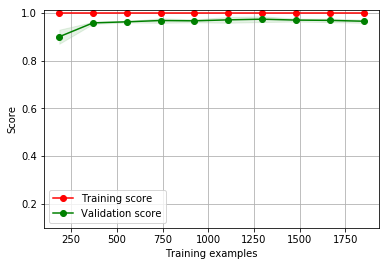

In [60]:
knn = KNeighborsClassifier(**best_parameters)  
train(knn, X_train, y_train)

## Evaluation

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       484
           1       1.00      0.96      0.98        95

   micro avg       0.99      0.99      0.99       579
   macro avg       1.00      0.98      0.99       579
weighted avg       0.99      0.99      0.99       579

Accuracy: 0.9930915371329879


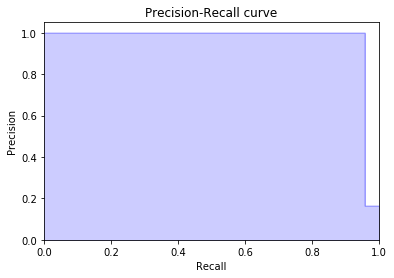

In [61]:
evaluate(knn, X_test, y_test)

# SVM

## Hyperparameter tuning with GridsearchCV

In [65]:
param_grid={'C':(0.1, 0.5), 'loss': ('hinge','squared_hinge')}
best_parameters = hyper_parameter_tuning(param_grid , LinearSVC(random_state=0), 3)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Best options
C: 0.5
loss: 'squared_hinge'


[Parallel(n_jobs=10)]: Done   6 out of  12 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=10)]: Done  12 out of  12 | elapsed:    1.5s finished


## Training with best parameters

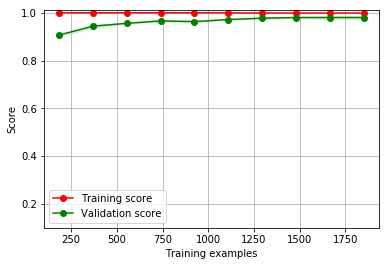

In [68]:
svm = LinearSVC(random_state=0, **best_parameters)  
train(svm, X_train, y_train)

## Evaluation

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       484
           1       1.00      0.95      0.97        95

   micro avg       0.99      0.99      0.99       579
   macro avg       0.99      0.97      0.98       579
weighted avg       0.99      0.99      0.99       579

Accuracy: 0.9913644214162349


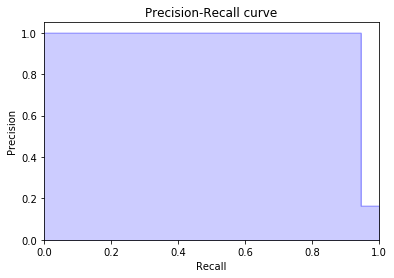

In [69]:
evaluate(svm, X_test, y_test)

# MLP

In [22]:
import gc
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, GRU, LSTM
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from tensorflow import set_random_seed

In [23]:
set_random_seed(7) # Define the seed in order to have reproducible data.

In [21]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

## Train

In [48]:
clean_up(model)

In [49]:
%matplotlib inline


input_shape = X_train.shape[1]
model = Sequential()
model.add(Dense(2000, input_shape=(input_shape,), init='glorot_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, init='glorot_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, init='glorot_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, init='glorot_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, init='glorot_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, init='glorot_normal', activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, validation_split=0.1)

y_pred = model.predict(X_test)



/home/spiros/env/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2000, kernel_initializer="glorot_normal", activation="relu", input_shape=(1000,))`
  
/home/spiros/env/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, kernel_initializer="glorot_normal", activation="relu")`
  
/home/spiros/env/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, kernel_initializer="glorot_normal", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/home/spiros/env/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="glorot_normal", activation="relu")`
  if sys.path[0] == '':
/home/spiros/env/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` cal

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2000)              2002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               50100     
__________

# Test

579/579 [==============================] - 0s 40us/step
LOSS ON TEST DATA=0.0735933759952164
ACCURACY ON TEST DATA=0.9930915371329879


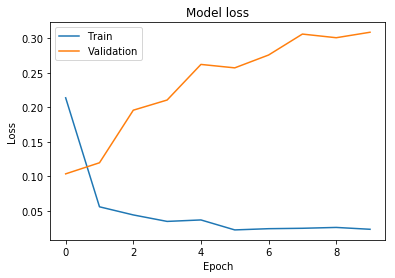

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       484
           1       0.99      0.97      0.98        95

   micro avg       0.99      0.99      0.99       579
   macro avg       0.99      0.98      0.99       579
weighted avg       0.99      0.99      0.99       579



In [51]:
evaluation = model.evaluate(x = X_test, y = y_test, verbose=1) 
loss = evaluation[0]
acc = evaluation[1]
print('LOSS ON TEST DATA='+str(loss))
print('ACCURACY ON TEST DATA='+str(acc))


# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test, y_pred.round()))